In [33]:
import sys
!{sys.executable} -m pip install ultralytics opencv-python matplotlib seaborn


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [34]:
import os
import shutil
import random
import yaml
import matplotlib.pyplot as plt
import cv2
import requests
import zipfile
from pathlib import Path
from ultralytics import YOLO
import ultralytics

ultralytics.checks()


Ultralytics 8.3.159 🚀 Python-3.13.5 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4060, 7805MiB)
Setup complete ✅ (12 CPUs, 30.9 GB RAM, 204.3/227.8 GB disk)


In [35]:
# Configuration
DATASET_URL = "https://public.roboflow.com/ds/NksRoboflowcommunityDSDataset"
DATASET_PATH = "asl_dataset" 
PROJECT_NAME = "ASL-YOLOv11"
RUN_NAME = "asl-letters-v11"

# Training configuration 
MODEL_SIZE = "yolo11n.pt"  
EPOCHS = 400
IMAGE_SIZE = 640
BATCH_SIZE = 16
PATIENCE = 20
SAVE_PERIOD = 10

print(f"Dataset path: {DATASET_PATH}")
print(f"Model: {MODEL_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Image size: {IMAGE_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Project: {PROJECT_NAME}")
print(f"Run name: {RUN_NAME}")

Dataset path: asl_dataset
Model: yolo11n.pt
Epochs: 400
Image size: 640
Batch size: 16
Project: ASL-YOLOv11
Run name: asl-letters-v11


In [36]:
def check_data_exists():
    if os.path.exists(DATASET_PATH):
        print(f"\nDataset folder '{DATASET_PATH}' exists.")
        return True
    
dataset_ready=check_data_exists()


Dataset folder 'asl_dataset' exists.


In [37]:
def analyze_dataset_structure(dataset_path):
    """Analyze the dataset structure and validate it."""
    print("Dataset Structure Analysis:")
    print("=" * 50)
    
    # Check main folders
    splits = ['train', 'valid', 'test']
    total_images = 0
    total_labels = 0
    
    for split in splits:
        split_path = os.path.join(dataset_path, split)
        images_path = os.path.join(split_path, 'images')
        labels_path = os.path.join(split_path, 'labels')
        
        if os.path.exists(images_path) and os.path.exists(labels_path):
            image_files = [f for f in os.listdir(images_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
            label_files = [f for f in os.listdir(labels_path) if f.lower().endswith('.txt')]
            
            print(f"{split.upper()} set:")
            print(f"  Images: {len(image_files)}")
            print(f"  Labels: {len(label_files)}")
            
            total_images += len(image_files)
            total_labels += len(label_files)
        else:
            print(f"Warning: {split} folder structure incomplete")
    
    print(f"\nTotal images: {total_images}")
    print(f"Total labels: {total_labels}")
    
    # Check for data.yaml
    yaml_path = os.path.join(dataset_path, 'data.yaml')
    if os.path.exists(yaml_path):
        print(f"\nFound data.yaml configuration file")
        return yaml_path
    else:
        print(f"\nWarning: data.yaml not found at {yaml_path}")
        return None

def load_and_display_yaml(yaml_path):
    """Load and display YAML configuration."""
    if not yaml_path or not os.path.exists(yaml_path):
        print("YAML file not found")
        return None
    
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)
    
    print("\nDataset Configuration (data.yaml):")
    print("=" * 50)
    for key, value in data.items():
        print(f"{key}: {value}")
    
    return data

# Analyze dataset if it exists
if os.path.exists(DATASET_PATH):
    yaml_config_path = analyze_dataset_structure(DATASET_PATH)
    yaml_data = load_and_display_yaml(yaml_config_path)
    
    if yaml_data:
        CLASS_NAMES = yaml_data.get('names', [])
        NUM_CLASSES = len(CLASS_NAMES)
        print(f"\nFound {NUM_CLASSES} classes: {CLASS_NAMES}")
else:
    print(f"Dataset not found at {DATASET_PATH}. Please download it first.")

Dataset Structure Analysis:
TRAIN set:
  Images: 1512
  Labels: 1512
VALID set:
  Images: 144
  Labels: 144
TEST set:
  Images: 72
  Labels: 72

Total images: 1728
Total labels: 1728

Found data.yaml configuration file

Dataset Configuration (data.yaml):
train: ../train/images
val: ../valid/images
test: ../test/images
nc: 26
names: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
roboflow: {'workspace': 'david-lee-d0rhs', 'project': 'american-sign-language-letters', 'version': 1, 'license': 'Public Domain', 'url': 'https://universe.roboflow.com/david-lee-d0rhs/american-sign-language-letters/dataset/1'}

Found 26 classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [38]:
def update_yaml_paths(yaml_path, dataset_path):
    """Update the YAML file paths to absolute paths."""
    if not yaml_path or not os.path.exists(yaml_path):
        print("Cannot update YAML - file not found")
        return None
    
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)
    
    # Update paths to absolute paths
    abs_dataset_path = os.path.abspath(dataset_path)
    data['path'] = abs_dataset_path
    data['train'] = 'train/images'
    data['val'] = 'valid/images'  # Roboflow uses 'valid' instead of 'val'
    data['test'] = 'test/images'
    
    # Save updated YAML
    updated_yaml_path = os.path.join(dataset_path, 'dataset_config.yaml')
    with open(updated_yaml_path, 'w') as f:
        yaml.dump(data, f, default_flow_style=False)
    
    print(f"Updated YAML configuration saved to: {updated_yaml_path}")
    print("\nUpdated configuration:")
    for key, value in data.items():
        print(f"{key}: {value}")
    
    return updated_yaml_path

# Update YAML configuration if dataset exists
if os.path.exists(DATASET_PATH) and 'yaml_config_path' in locals():
    updated_yaml_path = update_yaml_paths(yaml_config_path, DATASET_PATH)
else:
    print("Skipping YAML update - dataset not ready")

Updated YAML configuration saved to: asl_dataset/dataset_config.yaml

Updated configuration:
train: train/images
val: valid/images
test: test/images
nc: 26
names: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
roboflow: {'workspace': 'david-lee-d0rhs', 'project': 'american-sign-language-letters', 'version': 1, 'license': 'Public Domain', 'url': 'https://universe.roboflow.com/david-lee-d0rhs/american-sign-language-letters/dataset/1'}
path: /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/asl_dataset


In [39]:
def create_yaml_config(dataset_path, class_names, base_yaml_path=None):
    """Create YAML configuration file for YOLOv11."""
    # Start with base configuration if provided
    config = {}
    if base_yaml_path and os.path.exists(base_yaml_path):
        with open(base_yaml_path, 'r') as f:
            config = yaml.safe_load(f) or {}
        print(f"Using base configuration from: {base_yaml_path}")

    # Update with new paths and class information for YOLOv11
    config.update({
        'path': os.path.abspath(dataset_path),
        'train': 'train/images',
        'val': 'valid/images',  # Roboflow uses 'valid' instead of 'val'
        'test': 'test/images',
        'nc': len(class_names),
        'names': class_names
    })

    yaml_path = os.path.join(dataset_path, 'dataset_config.yaml')

    with open(yaml_path, 'w') as f:
        yaml.dump(config, f, default_flow_style=False)

    print(f"Created YAML config at: {yaml_path}")
    return yaml_path

# Create YAML configuration if dataset and class names are available
if os.path.exists(DATASET_PATH) and 'CLASS_NAMES' in locals():
    # Check if original data.yaml exists
    original_yaml_path = os.path.join(DATASET_PATH, 'data.yaml')
    
    # Create updated YAML configuration
    yaml_config_path = create_yaml_config(
        DATASET_PATH, 
        CLASS_NAMES, 
        original_yaml_path if os.path.exists(original_yaml_path) else None
    )

    # Display the config
    print("\nFinal Dataset Configuration:")
    print("=" * 50)
    with open(yaml_config_path, 'r') as f:
        print(f.read())
else:
    print("Cannot create YAML configuration - dataset not ready or class names not loaded")
    if not os.path.exists(DATASET_PATH):
        print(f"Dataset path does not exist: {DATASET_PATH}")
    if 'CLASS_NAMES' not in locals():
        print("CLASS_NAMES not defined - ensure dataset analysis completed successfully")

Using base configuration from: asl_dataset/data.yaml
Created YAML config at: asl_dataset/dataset_config.yaml

Final Dataset Configuration:
names:
- A
- B
- C
- D
- E
- F
- G
- H
- I
- J
- K
- L
- M
- N
- O
- P
- Q
- R
- S
- T
- U
- V
- W
- X
- Y
- Z
nc: 26
path: /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/asl_dataset
roboflow:
  license: Public Domain
  project: american-sign-language-letters
  url: https://universe.roboflow.com/david-lee-d0rhs/american-sign-language-letters/dataset/1
  version: 1
  workspace: david-lee-d0rhs
test: test/images
train: train/images
val: valid/images



Sample images from training set:


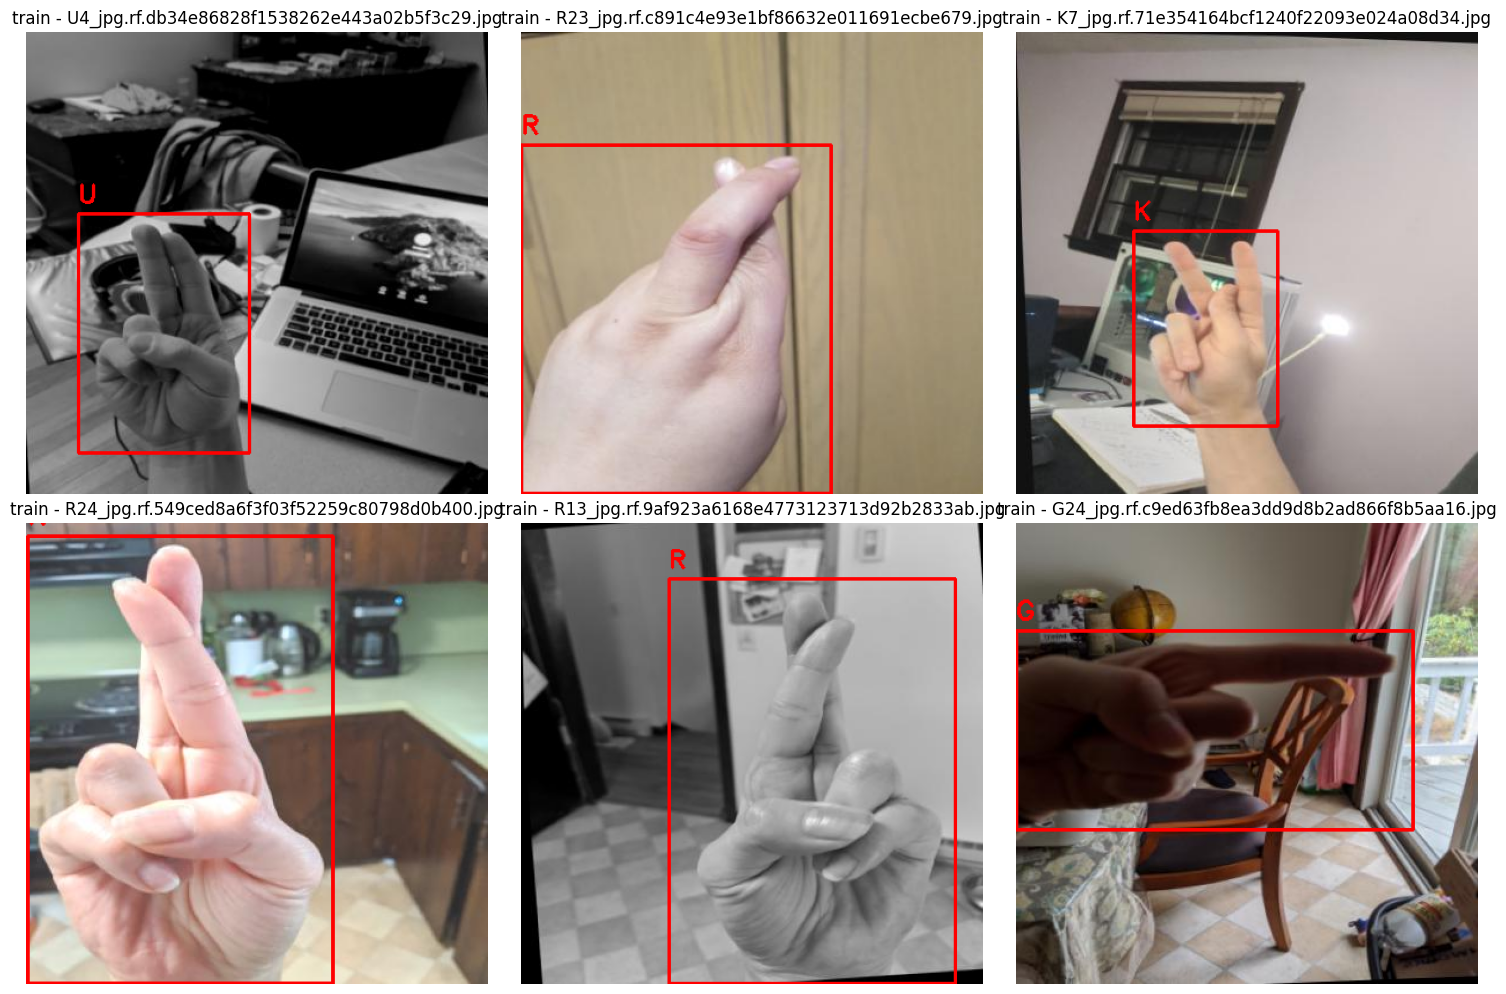

In [40]:
def visualize_sample_images(dataset_path, split='train', num_samples=6):
    """Visualize sample images with their annotations."""
    images_dir = os.path.join(dataset_path, split, 'images')
    labels_dir = os.path.join(dataset_path, split, 'labels')
    
    if not os.path.exists(images_dir) or not os.path.exists(labels_dir):
        print(f"Cannot visualize - {split} directories not found")
        return
    
    image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    if len(image_files) == 0:
        print(f"No images found in {images_dir}")
        return
    
    sample_files = random.sample(image_files, min(num_samples, len(image_files)))
    
    # Create subplot grid
    cols = 3
    rows = (num_samples + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx, img_file in enumerate(sample_files):
        row = idx // cols
        col = idx % cols
        
        # Load image
        img_path = os.path.join(images_dir, img_file)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w = image.shape[:2]
        
        # Load annotations
        base_name = os.path.splitext(img_file)[0]
        label_path = os.path.join(labels_dir, base_name + '.txt')
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
            
            # Draw bounding boxes
            for line in lines:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id, x_center, y_center, width, height = map(float, parts)
                    
                    # Convert normalized coordinates to pixel coordinates
                    x_center *= w
                    y_center *= h
                    width *= w
                    height *= h
                    
                    # Calculate box corners
                    x1 = int(x_center - width/2)
                    y1 = int(y_center - height/2)
                    x2 = int(x_center + width/2)
                    y2 = int(y_center + height/2)
                    
                    # Draw bounding box
                    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
                    
                    # Add class label
                    if 'CLASS_NAMES' in globals() and int(class_id) < len(CLASS_NAMES):
                        label = CLASS_NAMES[int(class_id)]
                        cv2.putText(image, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
        
        axes[row, col].imshow(image)
        axes[row, col].set_title(f'{split} - {img_file}')
        axes[row, col].axis('off')
    
    # Hide empty subplots
    for idx in range(len(sample_files), rows * cols):
        row = idx // cols
        col = idx % cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize samples if dataset is ready
if os.path.exists(DATASET_PATH):
    print("Sample images from training set:")
    visualize_sample_images(DATASET_PATH, 'train', 6)
else:
    print("Dataset not ready for visualization")

In [41]:
def train_yolov11_model(yaml_config_path, model_size, epochs, image_size, batch_size):
    """Train YOLOv11 model."""
    print(f"Starting YOLOv11 training with {model_size}")
    print(f"Configuration: epochs={epochs}, image_size={image_size}, batch_size={batch_size}")
    
    # Load YOLOv11 model
    model = YOLO(model_size)
    
    # Train the model
    results = model.train(
        data=yaml_config_path,
        epochs=epochs,
        imgsz=image_size,
        batch=batch_size,
        save=True,
        project=PROJECT_NAME,
        name=RUN_NAME,
        exist_ok=True,
        patience=PATIENCE,
        save_period=SAVE_PERIOD,
        # YOLOv11 specific parameters
        optimizer='auto',  # AdamW, Adam, SGD, or auto
        verbose=True,
        seed=42,
        deterministic=True,
        single_cls=False,
        rect=False,
        cos_lr=False,
        close_mosaic=10,
        resume=False,
        amp=True,  # Automatic Mixed Precision
        fraction=1.0,
        profile=False,
        overlap_mask=True,
        mask_ratio=4,
        dropout=0.0,
        val=True,
        plots=True,
        save_json=False,
        save_hybrid=False,
        conf=None,
        iou=0.7,
        max_det=300,
        half=False,
        dnn=False,
        augment=False
    )
    
    return model, results

# Start training if dataset is ready
if os.path.exists(DATASET_PATH) and 'updated_yaml_path' in locals():
    print("\nInitializing YOLOv11 model training...")
    print("This may take a while depending on your hardware and dataset size.")
    
    model, training_results = train_yolov11_model(
        updated_yaml_path, MODEL_SIZE, EPOCHS, IMAGE_SIZE, BATCH_SIZE
    )
    
    print("\n" + "="*60)
    print("TRAINING COMPLETED!")
    print("="*60)
else:
    print("Cannot start training - dataset not ready or YAML configuration missing")
    print("Please ensure the dataset is downloaded and properly structured.")


Initializing YOLOv11 model training...
This may take a while depending on your hardware and dataset size.
Starting YOLOv11 training with yolo11n.pt
Configuration: epochs=400, image_size=640, batch_size=16
New https://pypi.org/project/ultralytics/8.3.172 available 😃 Update with 'pip install -U ultralytics'
WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.159 🚀 Python-3.13.5 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4060, 7805MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=asl_dataset/dataset_config.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=400, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False,

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1147.7±376.4 MB/s, size: 12.7 KB)


train: Scanning /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/asl_dataset/train/labels.cache... 1512 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1512/1512 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 388.8±98.2 MB/s, size: 12.2 KB)


val: Scanning /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/asl_dataset/valid/labels.cache... 144 images, 0 backgrounds, 0 corrupt: 100%|██████████| 144/144 [00:00<?, ?it/s]


Plotting labels to ASL-YOLOv11/asl-letters-v11/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000333, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to ASL-YOLOv11/asl-letters-v11
Starting training for 400 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/400      2.47G      1.021       4.36      1.458         14        640: 100%|██████████| 95/95 [00:09<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.43it/s]

                   all        144        144     0.0275      0.721     0.0863     0.0717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/400      2.74G     0.8615       3.88      1.304         18        640: 100%|██████████| 95/95 [00:09<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.51it/s]

                   all        144        144      0.285      0.389      0.311      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      3/400      2.74G     0.9008      3.366      1.332         17        640: 100%|██████████| 95/95 [00:09<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.46it/s]

                   all        144        144      0.288      0.452      0.413      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      4/400      2.74G     0.9096      2.933      1.321         11        640: 100%|██████████| 95/95 [00:09<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.55it/s]

                   all        144        144      0.581      0.531      0.547      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      5/400      2.74G     0.8557      2.569      1.266         15        640: 100%|██████████| 95/95 [00:09<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.50it/s]

                   all        144        144      0.519      0.704      0.683      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      6/400      2.74G     0.8284      2.311       1.25         12        640: 100%|██████████| 95/95 [00:09<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.59it/s]

                   all        144        144      0.616      0.664      0.731      0.555

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      7/400      2.74G     0.8418      2.121      1.245         17        640: 100%|██████████| 95/95 [00:09<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.56it/s]

                   all        144        144      0.706      0.621      0.793      0.667

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      8/400      2.74G     0.7958      1.897      1.216         18        640: 100%|██████████| 95/95 [00:09<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.61it/s]

                   all        144        144      0.675      0.731      0.808      0.608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      9/400      2.74G     0.7875      1.766      1.203         14        640: 100%|██████████| 95/95 [00:09<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.59it/s]

                   all        144        144      0.679      0.787      0.823      0.661

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     10/400      2.74G     0.7452      1.645      1.184         14        640: 100%|██████████| 95/95 [00:09<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.57it/s]

                   all        144        144      0.791       0.69      0.806      0.677

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     11/400      2.74G     0.7507      1.541      1.173         19        640: 100%|██████████| 95/95 [00:09<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.61it/s]

                   all        144        144      0.763      0.801       0.87      0.697

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     12/400      2.74G     0.7563      1.511      1.181         16        640: 100%|██████████| 95/95 [00:09<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.62it/s]

                   all        144        144      0.857      0.817      0.912       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/400      2.74G     0.7409      1.428      1.168         17        640: 100%|██████████| 95/95 [00:09<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.62it/s]

                   all        144        144      0.837      0.743      0.888      0.705

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     14/400      2.74G     0.7425      1.361      1.168         16        640: 100%|██████████| 95/95 [00:09<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.67it/s]

                   all        144        144      0.788      0.787      0.887      0.721

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     15/400      2.74G     0.7474      1.365      1.184         15        640: 100%|██████████| 95/95 [00:09<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.66it/s]

                   all        144        144      0.901      0.844      0.948      0.768

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     16/400      2.74G     0.7391      1.295      1.165         20        640: 100%|██████████| 95/95 [00:09<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.63it/s]

                   all        144        144      0.856      0.814      0.914      0.732

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     17/400      2.74G     0.7221      1.233      1.151         20        640: 100%|██████████| 95/95 [00:09<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.62it/s]

                   all        144        144      0.895      0.809      0.922      0.762

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     18/400      2.74G     0.7232      1.217      1.153         15        640: 100%|██████████| 95/95 [00:09<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.68it/s]

                   all        144        144      0.795      0.825       0.92      0.722

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     19/400      2.74G     0.7071      1.155      1.141         19        640: 100%|██████████| 95/95 [00:09<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.69it/s]

                   all        144        144      0.842      0.874      0.925      0.769

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     20/400      2.74G     0.6959       1.13      1.132         15        640: 100%|██████████| 95/95 [00:09<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.68it/s]

                   all        144        144      0.826      0.916      0.944      0.736

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     21/400      2.74G     0.6961      1.118       1.14         13        640: 100%|██████████| 95/95 [00:09<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.66it/s]

                   all        144        144      0.844      0.787      0.908      0.693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     22/400      2.74G     0.6869      1.088      1.137         21        640: 100%|██████████| 95/95 [00:09<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.65it/s]

                   all        144        144      0.831      0.792      0.912      0.746

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     23/400      2.74G     0.6694      1.025      1.124         19        640: 100%|██████████| 95/95 [00:09<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.65it/s]

                   all        144        144      0.895      0.825      0.909      0.744

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     24/400      2.74G     0.6689     0.9878      1.115         15        640: 100%|██████████| 95/95 [00:09<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.70it/s]

                   all        144        144      0.922       0.82      0.939      0.749

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     25/400      2.74G     0.6596     0.9863      1.104         11        640: 100%|██████████| 95/95 [00:09<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.69it/s]

                   all        144        144      0.848      0.874      0.927      0.766

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     26/400      2.74G     0.6807     0.9904      1.123         10        640: 100%|██████████| 95/95 [00:09<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.65it/s]

                   all        144        144      0.852      0.839        0.9      0.726

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     27/400      2.74G     0.6757     0.9784      1.116         21        640: 100%|██████████| 95/95 [00:09<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.67it/s]

                   all        144        144      0.877      0.883      0.943      0.783

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     28/400      2.74G     0.6528     0.9219      1.108         15        640: 100%|██████████| 95/95 [00:09<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.70it/s]

                   all        144        144      0.886      0.878      0.948      0.755

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     29/400      2.74G     0.6682     0.9201      1.116         17        640: 100%|██████████| 95/95 [00:09<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.64it/s]

                   all        144        144      0.888      0.852      0.926      0.735

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     30/400      2.74G     0.6532     0.8845      1.101         21        640: 100%|██████████| 95/95 [00:09<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.69it/s]

                   all        144        144      0.876      0.886      0.945      0.787

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     31/400      2.74G     0.6678     0.8919      1.121         20        640: 100%|██████████| 95/95 [00:09<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]

                   all        144        144      0.873      0.826       0.92      0.715

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     32/400      2.74G     0.6525     0.8585      1.103         13        640: 100%|██████████| 95/95 [00:09<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.76it/s]

                   all        144        144      0.858      0.903      0.936      0.765

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     33/400      2.74G     0.6351      0.857       1.09         22        640: 100%|██████████| 95/95 [00:09<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.74it/s]

                   all        144        144      0.871       0.85      0.921      0.764

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     34/400      2.74G     0.6445     0.8293      1.102         21        640: 100%|██████████| 95/95 [00:09<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.74it/s]

                   all        144        144      0.906      0.866      0.933      0.748

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     35/400      2.74G     0.6606     0.8464      1.109         16        640: 100%|██████████| 95/95 [00:09<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.65it/s]

                   all        144        144      0.918      0.865      0.937      0.783

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     36/400      2.74G     0.6385      0.826      1.097         15        640: 100%|██████████| 95/95 [00:09<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]

                   all        144        144      0.781      0.924      0.935      0.742

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     37/400      2.74G     0.6347     0.7884      1.102         26        640: 100%|██████████| 95/95 [00:09<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.70it/s]

                   all        144        144      0.879      0.899      0.941      0.807

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     38/400      2.74G     0.6508      0.806      1.105         20        640: 100%|██████████| 95/95 [00:09<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.71it/s]

                   all        144        144      0.924      0.849      0.949      0.775

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     39/400      2.74G     0.6396      0.808      1.104         19        640: 100%|██████████| 95/95 [00:09<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.72it/s]

                   all        144        144      0.915      0.883      0.951      0.788

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     40/400      2.74G      0.642     0.7999      1.097         17        640: 100%|██████████| 95/95 [00:09<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.72it/s]

                   all        144        144      0.922      0.833      0.927      0.745

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     41/400      2.74G     0.6434     0.7547      1.098         12        640: 100%|██████████| 95/95 [00:09<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.72it/s]

                   all        144        144      0.896      0.849      0.931      0.748

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     42/400      2.74G     0.6326     0.7579      1.089         23        640: 100%|██████████| 95/95 [00:09<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.67it/s]

                   all        144        144      0.895      0.853      0.916      0.736

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     43/400      2.74G     0.6215     0.7573      1.082         16        640: 100%|██████████| 95/95 [00:09<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.72it/s]

                   all        144        144      0.856      0.871      0.913      0.737

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     44/400      2.74G     0.6293     0.7384        1.1         13        640: 100%|██████████| 95/95 [00:09<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]

                   all        144        144      0.888      0.849      0.932      0.762

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     45/400      2.74G     0.6349     0.7491      1.095         16        640: 100%|██████████| 95/95 [00:09<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]

                   all        144        144      0.895      0.847      0.923      0.777

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     46/400      2.74G     0.6213     0.7231      1.084         16        640: 100%|██████████| 95/95 [00:09<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.70it/s]

                   all        144        144      0.922      0.879      0.942      0.759

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     47/400      2.74G     0.6157     0.7004      1.075          6        640: 100%|██████████| 95/95 [00:09<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.78it/s]

                   all        144        144       0.91      0.883      0.935      0.767

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     48/400      2.74G     0.6193     0.7065      1.084         14        640: 100%|██████████| 95/95 [00:09<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.72it/s]

                   all        144        144      0.906      0.881      0.955      0.773

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     49/400      2.74G     0.6082     0.6895      1.074         17        640: 100%|██████████| 95/95 [00:09<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.71it/s]

                   all        144        144      0.843      0.893      0.935      0.771

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     50/400      2.74G     0.6303     0.7217      1.087         17        640: 100%|██████████| 95/95 [00:09<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.72it/s]

                   all        144        144      0.883       0.85      0.928      0.762

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     51/400      2.74G     0.6198     0.6892      1.081         20        640: 100%|██████████| 95/95 [00:09<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.72it/s]

                   all        144        144      0.929      0.839      0.944      0.774

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     52/400      2.74G     0.6195     0.6748      1.082         20        640: 100%|██████████| 95/95 [00:09<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]

                   all        144        144      0.943      0.869      0.949      0.774

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     53/400      2.74G     0.6042     0.6642      1.073         23        640: 100%|██████████| 95/95 [00:09<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]

                   all        144        144       0.93      0.841      0.942      0.756

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     54/400      2.74G     0.6085     0.6664      1.071         21        640: 100%|██████████| 95/95 [00:09<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.69it/s]

                   all        144        144      0.903      0.838      0.937      0.751

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     55/400      2.74G     0.6117     0.6517      1.077         25        640: 100%|██████████| 95/95 [00:09<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.69it/s]

                   all        144        144        0.9      0.868      0.944      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/400      2.74G     0.6005     0.6457      1.076         14        640: 100%|██████████| 95/95 [00:09<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]

                   all        144        144      0.901      0.848       0.93      0.783

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     57/400      2.74G     0.5939     0.6404      1.068         20        640: 100%|██████████| 95/95 [00:09<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.70it/s]

                   all        144        144      0.913      0.835      0.937      0.768
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 37, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

57 epochs completed in 0.157 hours.


Optimizer stripped from ASL-YOLOv11/asl-letters-v11/weights/last.pt, 5.5MB
Optimizer stripped from ASL-YOLOv11/asl-letters-v11/weights/best.pt, 5.5MB

Validating ASL-YOLOv11/asl-letters-v11/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.13.5 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4060, 7805MiB)
YOLO11n summary (fused): 100 layers, 2,587,222 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.89it/s]


                   all        144        144       0.88      0.899      0.943      0.808
                     A          5          5      0.923        0.8      0.962      0.828
                     B          9          9          1      0.743      0.975      0.857
                     C          3          3      0.866      0.667      0.755      0.595
                     D          6          6      0.977          1      0.995      0.875
                     E          4          4          1        0.9      0.995      0.895
                     F          8          8      0.855          1      0.995      0.889
                     G          5          5      0.798          1      0.995      0.885
                     H          9          9          1      0.827      0.995      0.771
                     I          2          2      0.865        0.5      0.566      0.503
                     J          8          8      0.859          1      0.982      0.686
                     

In [42]:
def validate_and_test_model(model, yaml_config_path, dataset_path):
    """Validate and test the trained model."""
    print("Running validation on validation set...")
    
    # Validate on validation set
    val_results = model.val(
        data=yaml_config_path,
        save_json=True,
        save_hybrid=False,
        conf=0.001,
        iou=0.6,
        max_det=300,
        half=False,
        device=None,
        dnn=False,
        plots=True,
        rect=False,
        split='val'
    )
    
    print(f"\nValidation Results:")
    print(f"mAP50: {val_results.box.map50:.4f}")
    print(f"mAP50-95: {val_results.box.map:.4f}")
    print(f"Precision: {val_results.box.mp:.4f}")
    print(f"Recall: {val_results.box.mr:.4f}")
    
    # Test on test set if it exists
    test_images_path = os.path.join(dataset_path, 'test', 'images')
    if os.path.exists(test_images_path):
        print("\nRunning inference on test set...")
        test_results = model.predict(
            source=test_images_path,
            save=True,
            save_txt=True,
            save_conf=True,
            save_crop=False,
            show=False,
            conf=0.25,
            iou=0.7,
            max_det=300,
            half=False,
            device=None,
            augment=False,
            agnostic_nms=False,
            retina_masks=False,
            embed=None,
            project=f'{PROJECT_NAME}_inference',
            name='test_results',
            exist_ok=True
        )
        print(f"Test results saved to: {PROJECT_NAME}_inference/test_results/")
    
    return val_results

# Run validation and testing if model was trained
if 'model' in locals():
    validation_results = validate_and_test_model(model, updated_yaml_path, DATASET_PATH)
else:
    print("No model available for validation")

Running validation on validation set...
WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.159 🚀 Python-3.13.5 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4060, 7805MiB)
YOLO11n summary (fused): 100 layers, 2,587,222 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1100.8±379.3 MB/s, size: 13.3 KB)


val: Scanning /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/asl_dataset/valid/labels.cache... 144 images, 0 backgrounds, 0 corrupt: 100%|██████████| 144/144 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.27it/s]


                   all        144        144      0.913      0.861      0.936      0.794
                     A          5          5      0.982        0.8      0.962      0.828
                     B          9          9          1      0.617      0.955      0.826
                     C          3          3      0.895      0.667      0.692      0.578
                     D          6          6          1      0.729      0.995      0.872
                     E          4          4      0.998          1      0.995      0.895
                     F          8          8       0.88          1      0.995      0.869
                     G          5          5      0.821          1      0.995      0.852
                     H          9          9          1      0.794      0.995      0.731
                     I          2          2      0.926        0.5      0.554      0.498
                     J          8          8          1      0.948      0.995       0.69
                     

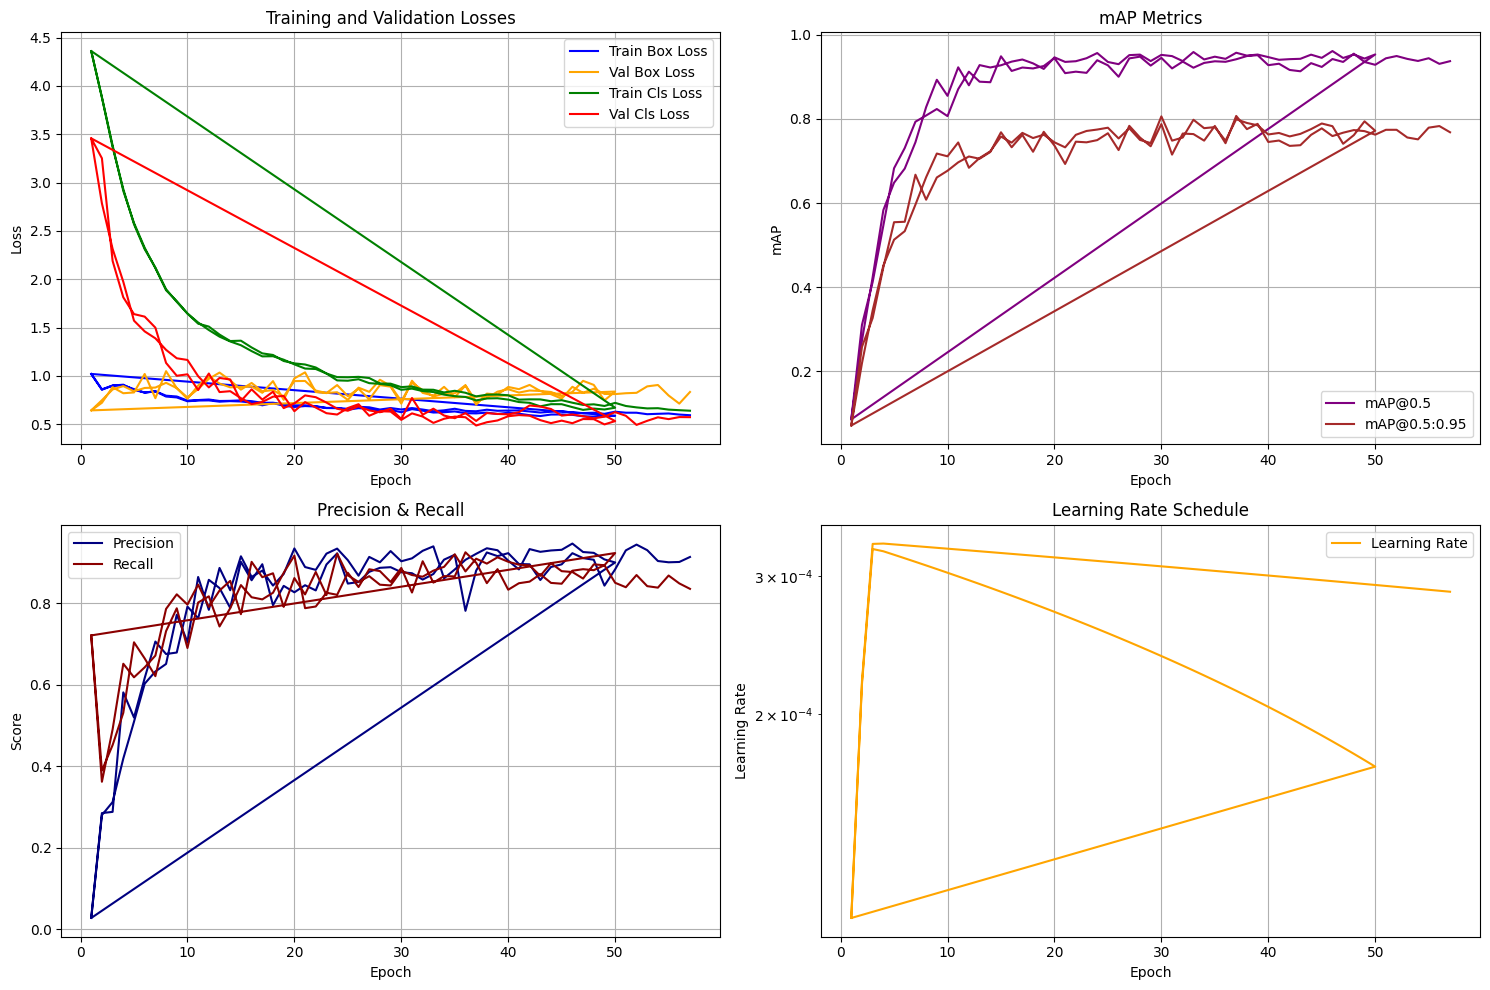


FINAL TRAINING METRICS
Final Epoch: 57

Final Losses:
   Train Box Loss: 0.5939
   Train Cls Loss: 0.6404
   Train DFL Loss: 1.0683

Validation Losses:
   Val Box Loss: 0.8342
   Val Cls Loss: 0.5736
   Val DFL Loss: 1.2615

Performance Metrics:
   Precision: 0.9130
   Recall: 0.8348
   mAP@0.5: 0.9368
   mAP@0.5:0.95: 0.7680


In [43]:
def plot_training_results(project_name, run_name):
    """Plot training metrics from the results."""
    import pandas as pd
    import matplotlib.pyplot as plt
    
    results_dir = os.path.join(project_name, run_name)
    results_csv = os.path.join(results_dir, 'results.csv')
    
    if not os.path.exists(results_csv):
        print(f"Results CSV not found at: {results_csv}")
        return
    
    # Load results
    df = pd.read_csv(results_csv)
    df.columns = df.columns.str.strip()  # Remove whitespace
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Loss curves
    axes[0, 0].plot(df['epoch'], df['train/box_loss'], label='Train Box Loss', color='blue')
    axes[0, 0].plot(df['epoch'], df['val/box_loss'], label='Val Box Loss', color='orange')
    axes[0, 0].plot(df['epoch'], df['train/cls_loss'], label='Train Cls Loss', color='green')
    axes[0, 0].plot(df['epoch'], df['val/cls_loss'], label='Val Cls Loss', color='red')
    axes[0, 0].set_title('Training and Validation Losses')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # 2. mAP metrics
    axes[0, 1].plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5', color='purple')
    axes[0, 1].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95', color='brown')
    axes[0, 1].set_title('mAP Metrics')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('mAP')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # 3. Precision and Recall
    axes[1, 0].plot(df['epoch'], df['metrics/precision(B)'], label='Precision', color='navy')
    axes[1, 0].plot(df['epoch'], df['metrics/recall(B)'], label='Recall', color='darkred')
    axes[1, 0].set_title('Precision & Recall')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # 4. Learning Rate
    axes[1, 1].plot(df['epoch'], df['lr/pg0'], label='Learning Rate', color='orange')
    axes[1, 1].set_title('Learning Rate Schedule')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    axes[1, 1].set_yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    final_epoch = df.iloc[-1]
    print("\n" + "="*50)
    print("FINAL TRAINING METRICS")
    print("="*50)
    print(f"Final Epoch: {int(final_epoch['epoch'])}")
    print(f"\nFinal Losses:")
    print(f"   Train Box Loss: {final_epoch['train/box_loss']:.4f}")
    print(f"   Train Cls Loss: {final_epoch['train/cls_loss']:.4f}")
    print(f"   Train DFL Loss: {final_epoch['train/dfl_loss']:.4f}")
    print(f"\nValidation Losses:")
    print(f"   Val Box Loss: {final_epoch['val/box_loss']:.4f}")
    print(f"   Val Cls Loss: {final_epoch['val/cls_loss']:.4f}")
    print(f"   Val DFL Loss: {final_epoch['val/dfl_loss']:.4f}")
    print(f"\nPerformance Metrics:")
    print(f"   Precision: {final_epoch['metrics/precision(B)']:.4f}")
    print(f"   Recall: {final_epoch['metrics/recall(B)']:.4f}")
    print(f"   mAP@0.5: {final_epoch['metrics/mAP50(B)']:.4f}")
    print(f"   mAP@0.5:0.95: {final_epoch['metrics/mAP50-95(B)']:.4f}")

# Plot training results if available
if 'model' in locals():
    plot_training_results(PROJECT_NAME, RUN_NAME)
else:
    print("No training results available to plot")

Testing model on 3 random test images:

Test image 1: X9_jpg.rf.28187742b082579d85eda81cf98bf5bb.jpg

image 1/1 /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/asl_dataset/test/images/X9_jpg.rf.28187742b082579d85eda81cf98bf5bb.jpg: 640x640 1 X, 3.2ms
Speed: 1.3ms preprocess, 3.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


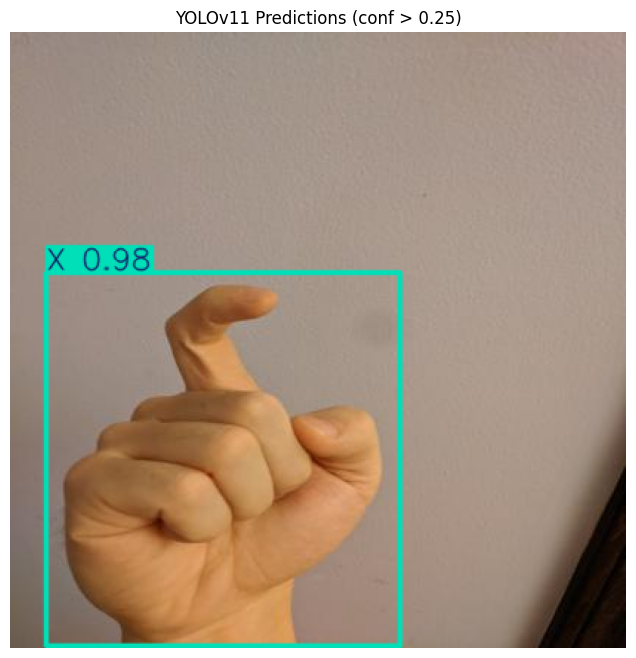


Detections found: 1
  Detection 1: X (confidence: 0.979)

Test image 2: M20_jpg.rf.aa9f2799d2cbe8f51363ec2862b427a6.jpg

image 1/1 /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/asl_dataset/test/images/M20_jpg.rf.aa9f2799d2cbe8f51363ec2862b427a6.jpg: 640x640 1 N, 1 O, 3.1ms
Speed: 1.1ms preprocess, 3.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


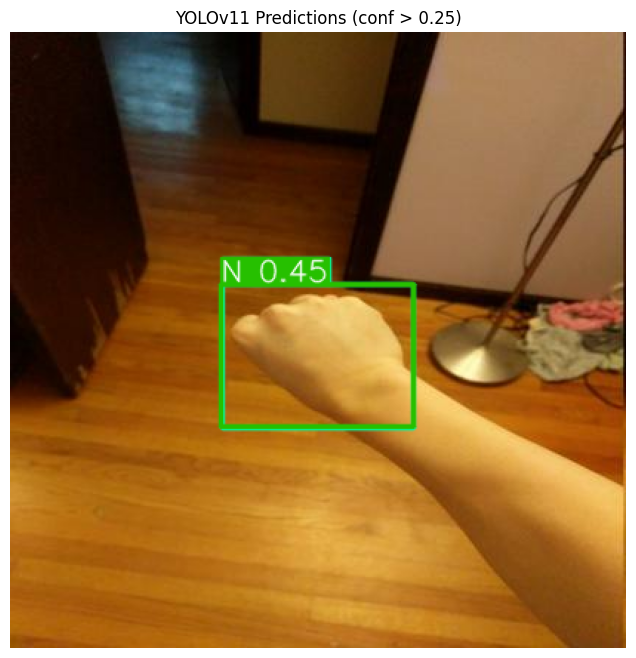


Detections found: 2
  Detection 1: N (confidence: 0.454)
  Detection 2: O (confidence: 0.315)

Test image 3: F17_jpg.rf.6097db79e0385af55b85ad5fa03cdc55.jpg

image 1/1 /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/asl_dataset/test/images/F17_jpg.rf.6097db79e0385af55b85ad5fa03cdc55.jpg: 640x640 1 F, 3.1ms
Speed: 1.1ms preprocess, 3.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


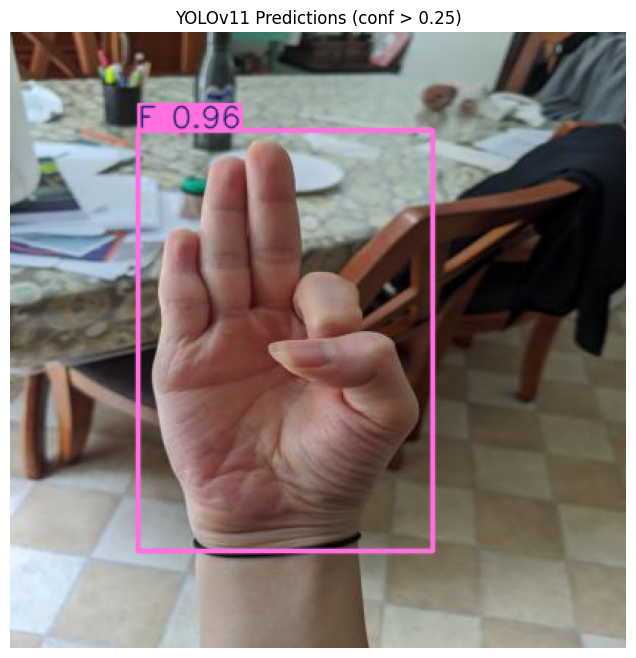


Detections found: 1
  Detection 1: F (confidence: 0.956)


In [44]:
def predict_single_image(model, image_path, conf_threshold=0.25, save_result=True):
    """Make prediction on a single image and visualize results."""
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return
    
    results = model.predict(
        source=image_path,
        conf=conf_threshold,
        save=save_result,
        show=False,
        project=f'{PROJECT_NAME}_predictions',
        name='single_image',
        exist_ok=True
    )
    
    # Display results
    for r in results:
        # Plot results
        im_array = r.plot()
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f'YOLOv11 Predictions (conf > {conf_threshold})')
        plt.show()
        
        # Print detection info
        if len(r.boxes) > 0:
            print(f"\nDetections found: {len(r.boxes)}")
            for i, box in enumerate(r.boxes):
                class_id = int(box.cls[0])
                confidence = float(box.conf[0])
                if 'CLASS_NAMES' in globals() and class_id < len(CLASS_NAMES):
                    class_name = CLASS_NAMES[class_id]
                else:
                    class_name = f"Class_{class_id}"
                print(f"  Detection {i+1}: {class_name} (confidence: {confidence:.3f})")
        else:
            print("No detections found")
    
    return results

def predict_on_test_samples(model, dataset_path, num_samples=3):
    """Test the model on random samples from test set."""
    test_images_path = os.path.join(dataset_path, 'test', 'images')
    
    if not os.path.exists(test_images_path):
        print(f"Test images not found at: {test_images_path}")
        return
    
    image_files = [f for f in os.listdir(test_images_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    
    if len(image_files) == 0:
        print("No test images found")
        return
    
    sample_files = random.sample(image_files, min(num_samples, len(image_files)))
    
    print(f"Testing model on {len(sample_files)} random test images:")
    print("=" * 60)
    
    for i, img_file in enumerate(sample_files):
        img_path = os.path.join(test_images_path, img_file)
        print(f"\nTest image {i+1}: {img_file}")
        predict_single_image(model, img_path, conf_threshold=0.25, save_result=False)

# Test predictions if model is available
if 'model' in locals() and os.path.exists(DATASET_PATH):
    predict_on_test_samples(model, DATASET_PATH, num_samples=3)
else:
    print("Model not available for testing or dataset not found")

Running validation...
Ultralytics 8.3.159 🚀 Python-3.13.5 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4060, 7805MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1297.5±517.8 MB/s, size: 13.7 KB)


val: Scanning /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/asl_dataset/valid/labels.cache... 144 images, 0 backgrounds, 0 corrupt: 100%|██████████| 144/144 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 11.18it/s]


                   all        144        144       0.88      0.898      0.941      0.807
                     A          5          5      0.922        0.8      0.962      0.828
                     B          9          9          1      0.743      0.975      0.857
                     C          3          3      0.867      0.667      0.747      0.592
                     D          6          6      0.977          1      0.995      0.875
                     E          4          4          1      0.904      0.995      0.895
                     F          8          8      0.855          1      0.982      0.878
                     G          5          5      0.799          1      0.995      0.885
                     H          9          9          1      0.826      0.995      0.771
                     I          2          2      0.866        0.5      0.557      0.496
                     J          8          8      0.859          1      0.982      0.686
                     

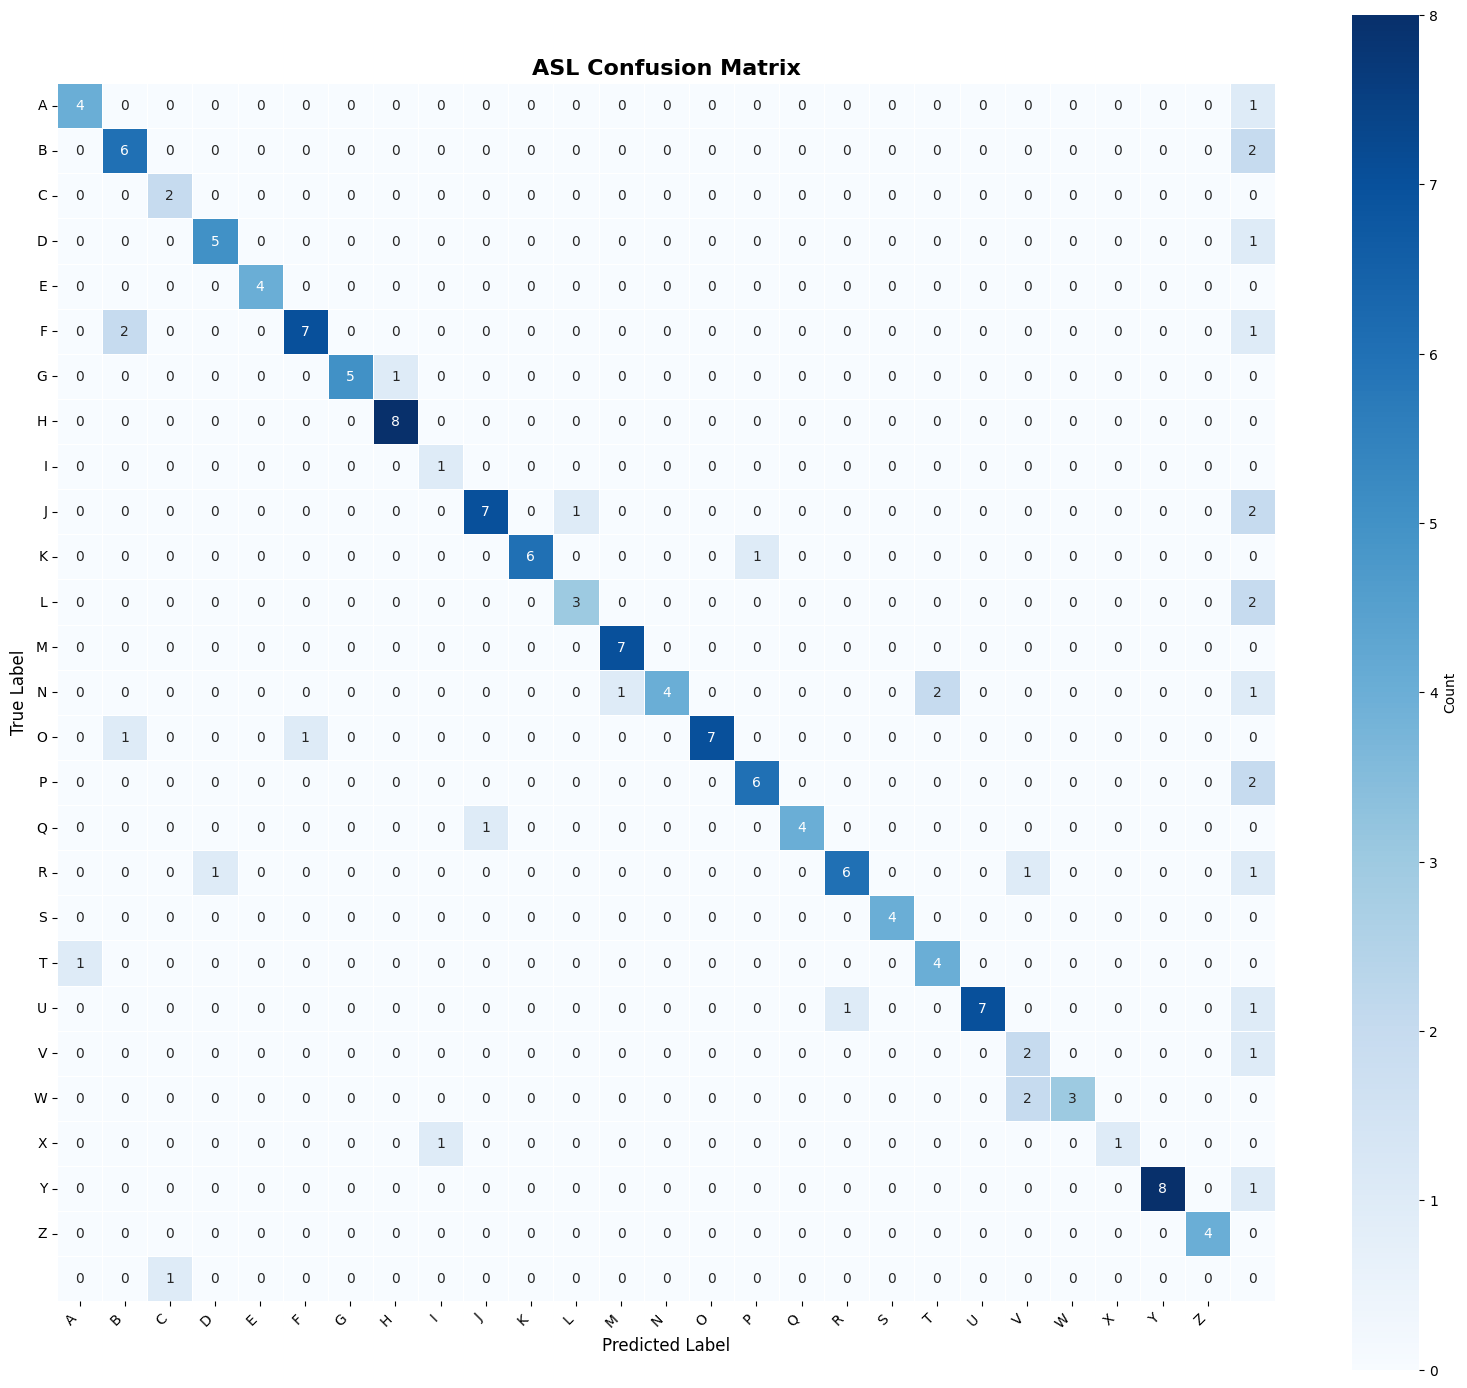

Overall Accuracy from Confusion Matrix: 0.7812
Running inference on test set...

image 1/72 /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/asl_dataset/test/images/A22_jpg.rf.f02ad8558ce1c88213b4f83c0bc66bc8.jpg: 640x640 1 A, 3.5ms
image 2/72 /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/asl_dataset/test/images/B14_jpg.rf.ed5ba6d44f55ab03e62d2baeac4aa1aa.jpg: 640x640 1 B, 2.8ms
image 3/72 /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/asl_dataset/test/images/B15_jpg.rf.0f0628552139144fc67c453e1f1b7b15.jpg: 640x640 1 B, 2.5ms
image 4/72 /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/asl_dataset/test/images/B19_jpg.rf.69527cc1f34d694cc04e55db80ed9b1a.jpg: 640x640 1 B, 2.5ms
image 5/72 /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/asl_dataset/test/images/C17_jpg.rf.ceb81f8ae3c3673bd060ebe71848eca8.jpg: 640x640 1 C, 2.4ms
image 6/72 /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspell

In [48]:
def plot_custom_confusion_matrix(val_results, model):
    """Plot custom confusion matrix from validation results."""
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    # Get confusion matrix and class names
    conf_matrix = np.array(val_results.confusion_matrix.matrix)
    class_names = list(model.names.values())
    
    # Determine if normalized or count data
    is_normalized = conf_matrix.max() <= 1.0
    
    # Create the plot
    plt.figure(figsize=(16, 14))
    
    if is_normalized:
        sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues',
                    square=True, cbar_kws={'label': 'Normalized Frequency'},
                    xticklabels=class_names, yticklabels=class_names,
                    linewidths=0.5)
        title = 'ASL Confusion Matrix (Normalized)'
    else:
        sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues',
                    square=True, cbar_kws={'label': 'Count'},
                    xticklabels=class_names, yticklabels=class_names,
                    linewidths=0.5)
        title = 'ASL Confusion Matrix'
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Print accuracy statistics
    if is_normalized:
        accuracy = np.trace(conf_matrix) / len(conf_matrix)
    else:
        total_samples = np.sum(conf_matrix)
        correct_predictions = np.trace(conf_matrix)
        accuracy = correct_predictions / total_samples
        print(f"Overall Accuracy from Confusion Matrix: {accuracy:.4f}")

def validate_model(model, yaml_config_path):
    """Validate the trained model."""
    print("Running validation...")

    # Validate on validation set
    val_results = model.val(
        data=yaml_config_path,
        save=False,          # Don't save prediction images
        save_json=False,     # Don't save JSON results
        save_txt=False,      # Don't save txt results
        plots=True          # Don't save automatic plots
    )

    print(f"mAP50: {val_results.box.map50:.4f}")
    print(f"mAP50-95: {val_results.box.map:.4f}")
    
    # Plot custom confusion matrix
    print("\nGenerating custom confusion matrix...")
    plot_custom_confusion_matrix(val_results, model)

    return val_results

def test_model(model, test_images_path):
    """Test the model on test set."""
    print("Running inference on test set...")

    test_results = model.predict(
        source=test_images_path,
        save=True,
        project='yolo_testing',
        name='test_results',
        exist_ok=True,     
        conf=0.25,
        iou=0.45
    )

    return test_results

# Validate the model
validation_results = validate_model(model, yaml_config_path)

# Test on test set
test_images_path = os.path.join(DATASET_PATH, 'test', 'images')
test_results = test_model(model, test_images_path)



In [49]:
# benchmark:
# Benchmark model
print("*"*50)
print("Benchmarking...")
model.benchmark()
print("*"*50)

Setup complete ✅ (12 CPUs, 30.9 GB RAM, 204.5/227.8 GB disk)

Benchmarks complete for yolo11n.pt on coco8.yaml at imgsz=640 (60.51s)
Benchmarks legend:  - ✅ Success  - ❎ Export passed but validation failed  - ❌️ Export failed
                   Format Status❔  Size (MB) metrics/mAP50-95(B) Inference time (ms/im)     FPS
0                 PyTorch       ✅        5.2                 0.0                    4.6  217.46
1             TorchScript       ✅       10.4                 0.0                   2.33  429.85
2                    ONNX       ✅       10.0                 0.0                   3.77  265.21
3                OpenVINO       ❌        0.0                   -                      -       -
4                TensorRT       ✅       17.2                 0.0                   1.65  606.92
5                  CoreML       ❌        0.0                   -                      -       -
6   TensorFlow SavedModel       ❌        0.0                   -                      -       -
7     